<img width="8%" alt="Hugging Face.png" src="https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/.github/assets/logos/Hugging%20Face.png" style="border-radius: 15%">

# Travail 3 | tâche 1 

**Auteur:** [Nicolas Bourez](https://www.linkedin.com/in/nicolasbourez)

**Dernière mise à jour:** 2024-11-28 (Créé: 2024-11-26)

### Données

dataset: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset | "/kaggle/input/enron-email-dataset/emails.csv"

preprocessing of the dataset: https://www.kaggle.com/code/gpreda/parse-and-process-enron-emails-dataset 

dataset_processed_small: https://www.kaggle.com/code/gpreda/explore-enron-emails-with-langchain-and-llama-v2/notebook | "/kaggle/input/parse-and-process-enron-emails-dataset/proc_email.csv"

### Réferences

template: https://github.com/jupyter-naas/awesome-notebooks/blob/master/Hugging%20Face/Hugging_Face_Question_Answering_from_PDF.ipynb

code: https://www.kaggle.com/code/gpreda/explore-enron-emails-with-langchain-and-llama-v2/notebook

## Le résumé d’un document en quelques lignes qui contiennent l’essentiel du contenu

Ce notebook a pour but d'analyser et comparer 8 modèles de LLM's sur la tâche décrite ci-dessus. Pour cela, des modèles de la libraire HuggingFace (à faible nombre de paramètres < 4B) vont être utilisés:

1. Minitron : https://huggingface.co/nvidia/Minitron-4B-Base
2. Llama 3.2 : https://huggingface.co/meta-llama/Llama-3.2-1B
3. SmolLM : https://huggingface.co/HuggingFaceTB/SmolLM-1.7B
4. Phi-3 : https://huggingface.co/microsoft/Phi-3-small-128k-instruct
5. Qwen2.5 : https://huggingface.co/Qwen/Qwen2.5-3B
6. Gemma : https://huggingface.co/google/gemma-2b-it
7. T5 : https://huggingface.co/google-t5/t5-3b
8. MobileLLM : https://huggingface.co/facebook/MobileLLM-1B
9. Opt : https://huggingface.co/facebook/opt-2.7b
10. OpenELM : https://huggingface.co/apple/OpenELM-3B-Instruct
11. Stablelm-zephyr : https://huggingface.co/stabilityai/stablelm-zephyr-3b
12. Cerebras : https://huggingface.co/cerebras/Cerebras-GPT-2.7B
13. Gpt-neo : https://huggingface.co/EleutherAI/gpt-neo-2.7B
14. Dolly : https://huggingface.co/databricks/dolly-v2-3b
15. h2o-danube3-4b-chat : https://huggingface.co/h2oai/h2o-danube3-4b-chat
16. Pythia : https://huggingface.co/EleutherAI/pythia-2.8b
17. TinyLlama : https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0
18. RedPajama : https://huggingface.co/togethercomputer/RedPajama-INCITE-Chat3B-v1
19. Allenai OLMO : https://huggingface.co/allenai/OLMo-1B-hf
20. Opt-iml-max : https://huggingface.co/facebook/opt-iml-max-1.3b

### Selection des modèles

1. Llama 3.2 : https://huggingface.co/meta-llama/Llama-3.2-1B Note: besoin d'une autorisation de Facebook OK
6. Gemma : https://huggingface.co/google/gemma-2b-it Note: besoin d'une autorisation de Google OK
8. MobileLLM : https://huggingface.co/facebook/MobileLLM-1B
12. Cerebras : https://huggingface.co/cerebras/Cerebras-GPT-2.7B
14. Dolly : https://huggingface.co/databricks/dolly-v2-3b
16. Pythia : https://huggingface.co/EleutherAI/pythia-2.8b
18. RedPajama : https://huggingface.co/togethercomputer/RedPajama-INCITE-Chat3B-v1
20. Opt-iml-max : https://huggingface.co/facebook/opt-iml-max-1.3b

## Input

### Install packages

In [1]:
#!pip install transformers accelerate einops xformers bitsandbytes sentence_transformers datasets bert_score

### Import libraries

In [1]:
import torch
import transformers
from transformers import AutoTokenizer, pipeline
from loadtime import LoadTime
import evaluate

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from datasets import *

torch.cuda.empty_cache()

/home/nibou/Documents/Master2_courses/Q1/IFT7022_NLP/Projet_git/NLP_p1/tp3_nico/tp3_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Choix des modèles

In [3]:
models = ["meta-llama/Llama-3.2-1B","google/gemma-2b-it","facebook/MobileLLM-1B","cerebras/Cerebras-GPT-2.7B","databricks/dolly-v2-3b","EleutherAI/pythia-2.8b","togethercomputer/RedPajama-INCITE-Chat-3B-v1","facebook/opt-iml-max-1.3b"]

### Definir le modèle, l'appareil, et la configuration bitsandbytes

In [4]:
device = f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

model_path = "facebook/opt-iml-max-1.3b"

# utiliser moins de mémoire GPU
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

Using device: cuda:0


### Preparer le modèle et le tokenizer

In [5]:
def init_model(model_path):
    model_config = transformers.AutoConfig.from_pretrained(model_path)
    model = LoadTime(name=model_path,
                    fn=lambda: transformers.AutoModelForCausalLM.from_pretrained(
        model_path,
        trust_remote_code=True,
        config=model_config,
        quantization_config=bnb_config,
        device_map=device,
    ))()

    if model_path == "facebook/MobileLLM-1B":
        tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
    elif model_path == "dolly-v2-3b" or model_path == "EleutherAI/pythia-2.8b":
        tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="left")
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Explicitly set pad_token_id if not already defined
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    return model, tokenizer

#model, tokenizer = init_model(model_path) # init model

### Définir le pipeline

In [6]:
def init_pipeline(model, tokenizer):
    
    return pipeline("text-generation",model=model,tokenizer=tokenizer,torch_dtype=torch.float16,device_map="auto",max_new_tokens = 50)

#query_pipeline = init_pipeline(model, tokenizer) # init pipeline

In [7]:
# checking again that everything is working fine
def generate_example(query_pipeline):
    prompt = "Please explain what was the Enron scandal. Keep it in 100 words.### Answer:"
    result = query_pipeline(prompt)

    # print generated text after removing the input text
    answer = result[0]['generated_text']
    # remove everything before A:
    answer = answer[answer.find('Answer:')+8:]
    print(answer)

#generate_example(query_pipeline)

## Enron dataset

Le preprocessing des emails est disponible dans un autre notebook https://www.kaggle.com/code/gpreda/parse-and-process-enron-emails-dataset. Seul les emails plus grand que 400 charactères ont été conservés afin que la tâche de résumé ait plus de sens et d'éviter d'avoir des réponses vides lorsque le texte est trop court.

### Import du dataset

In [8]:
small_df = pd.read_csv('data/proc_email.csv')

print(f"Small dataset shape: {small_df.shape}")
print("Small dataset columns:")
print(small_df.columns)

small_df = small_df.sample(n=100, random_state=42)

Small dataset shape: (3287, 6)
Big dataset shape: (102173, 7)
Small dataset columns:
Index(['Message-ID', 'To', 'From', 'X-To', 'X-From', 'content'], dtype='object')


### Prompt Engineering

Dans la section suivante, on définit 4 prompts:

* basic_prompt: C'est un token qu'on ajoute après un texte que l'on veut résumer. C'est le prompt de référence
* middle_prompt: C'est un prompt plus élaboré que basic, où on associe le modèle à un rôle et où on lui donne des instructions spécifiques et précises sur la tâche qu'il doit accomplir

* expert zero_shot: Prompt assez semble au middle_prompt, sauf qu'on donne d'abord les instructions de manière explicite, et où l'on indique via un string "Agent: " que notre modèle doit commencer à générer le résumé

* expert_few_shot: Prompt semblable au précédent, auquel on a ajouté deux exemples de résumé de mails, avant de demander à l'agent de commencer sa tâche.

In [9]:
prompts = {}

basic_prompt = "### tl;dr"
prompts["basic"] = basic_prompt

middle_prompt = ("You are an agent in the natural language processing field and you have to summarize the given document."
                 "To accomplish this task, you need to find all the important information and present it in a concise manner." 
                 "The summary you will provide need to be shorter than the original document, and it should contain all the key points.")
prompts["middle"] = middle_prompt

expert_prompt_zero_shot = ("Instructions: The next one is a summarizer agent. it creates a concise and comprehensive summary of the provided document, be it an article, post, conversation, email, or passage, while adhering to these guidelines:"
"Craft a summary that is detailed, thorough, in-depth, and complex, while maintaining clarity and conciseness."
"Incorporate main ideas and essential information, eliminating extraneous language and focusing on critical aspects."
"Rely strictly on the provided text, without including external information."
"Agent:")
prompts["expert_zero_shot"] = expert_prompt_zero_shot 

expert_prompt_few_shot = ("Instructions: The next one is a summarizer agent. it creates a concise and comprehensive summary of documents, be it an article, post, conversation, email, or passage, while adhering to these guidelines:"
"Craft a summary that is detailed, thorough, in-depth, and complex, while maintaining clarity and conciseness."
"Incorporate main ideas and essential information, eliminating extraneous language and focusing on critical aspects."
"Rely strictly on the provided text, without including external information.\n"
"Document: Thanks for all your help with Sempra.  Hard work, but certainly worth it.  On "
"another note, Mike and I have discussed this $2 million issue with American "
"Coal, and the interest rate hedge in the MPR.  Bottom line, we are not taking "
"this hit.  It seems it was a problem with Treasury, so send it to them."  

"Thanks. "

"Jeff"
"Agent: Jeff is thanking someone for their work on Sempra. \n"
"He mentions discussing a $2 million issue with American Coal and an interest rate hedge in the MPR with Mike. "
"He concludes that they will not absorb the loss, as it seems to be Treasury's fault, and asks to pass the issue to Treasury. \n"
"Document: 596368 - changed to powerex"





"Kerri Thompson@ENRON"
"04/30/2001 02:15 PM"
"To: Kate Symes/PDX/ECT@ECT"
"cc: " 

"Subject: apb"

"596368"
"broker has powerex"

"Agent: The broker for transaction 596368 is now listed as Powerex."
)
prompts["expert_few_shot"] = expert_prompt_few_shot



### Résumés des emails

Les deux fonctions suivantes permettent de résumer 100 différents e-mails selon les 4 prompts et de stocker les résultats dans un fichier csv, qu'on pourra évaluer la suite.

In [10]:
hf_dataset = Dataset.from_pandas(small_df)

from time import time
import os

# if time list is not defined, define it
if not os.path.exists("results/time_list.csv"):
    time_list = {}

# if time list is defined, load it
else:
    time_list_df = pd.read_csv("results/time_list.csv")
    time_list = dict(zip(time_list_df["model"], time_list_df["time"]))

print(time_list)
# Process a single email
def process_email(row, key, summary_prompt, query_pipeline):
    email_content = row['content']
    
    if key == "expert_few_shot":
        prompt = summary_prompt + f"\n Document: {email_content}\n #Agent:"
    elif key == "middle":
        prompt = (
            f"### Instruction:\n{summary_prompt}\n\n"
            f"### Document:\n{email_content}\n\n"
            "### Summary of the Document:"
        )
    else:
        prompt = f"\n\n{email_content}" + summary_prompt
    
    # Query the pipeline
    result = query_pipeline(prompt)
    answer = result[0]['generated_text']
    
    # Post-process the result
    if key == "expert_few_shot":
        generated_text = answer[answer.find('#Agent:')+7:]
    elif key == "middle":
        generated_text = answer[answer.find("Summary of the Document:")+25:]
    else:
        generated_text = answer[answer.find(summary_prompt)+len(list(summary_prompt)):]
    
    return generated_text

# Iterate over prompts and process the dataset

def process_dataset(prompts, nb_emails, model_path, query_pipeline):
    res_list = []
    avg_time = 0
    for key, summary_prompt in prompts.items():
        torch.cuda.empty_cache()  # Clear GPU memory
        
        # Process the dataset with tqdm for progress tracking
        res_list_p = []
        for i in tqdm(range(nb_emails), desc=f"Processing emails for {key}", unit="email"):
            row = hf_dataset[i]
            start = time()
            generated_text = process_email(row, key, summary_prompt, query_pipeline)
            end = time()
            avg_time += end - start
            res_list_p.append(generated_text)
        
        res_list.append(res_list_p)

    print("Average time per email: ", avg_time / (nb_emails*len(prompts)))

    # Convert results to DataFrame
    np_res = np.array(res_list).T
    res_df = pd.DataFrame(np_res, columns=[key for key in prompts.keys()])

    # Save the results
    index_model = models.index(model_path)
    model_name = model_path.split("/")[-1]
    file_name = f"results/llm_{index_model}_{model_name}_small.csv"
    res_df.to_csv(file_name, index=False)

    return avg_time / (nb_emails*len(prompts))

#model_name = model_path.split("/")[-1]
#time_list[model_name] = process_dataset(prompts, 10, model_path, query_pipeline)

# save time list
#time_list_df = pd.DataFrame(list(time_list.items()), columns=["model", "time"])
#time_list_df.to_csv("results/time_list.csv", index=False)

## Analyze des résultats

In [11]:
# Evaluate the results using bleu, rouge and bertscore

bleu_metric = evaluate.load('bleu')
rouge_metric = evaluate.load('rouge')
bertscore_metric = evaluate.load('bertscore')

### Création des références

Pour évaluer la performance de nos modèles, nous allons comparer les résumés obtenus à des modèles spécialisés dans cette tâche à savoir:

* google/pegasus-cnn_dailymail
* facebook/bart-large-cnn

Nous ferons ensuite la moyenne des scores obtenus

#### Pegasus and Bart

In [12]:
model_path = "facebook/bart-large-cnn"
model_name = model_path.split("/")[-1]
model_name = model_name.split("_")[0]
model_name = model_name.split("-")[0]
print(f"Evaluating model {model_name}")
summarizer = None

def init_pipe_summarizer(model_path):
    return pipeline("summarization", model=model_path,max_length=60,device='cpu')

#summarizer = init_pipe_summarizer(model_path)

Evaluating model bart


In [13]:

# iterate on the rows of the small_df
def process_references(model_name, nb_emails, small_df, summarizer):
    res_list = []
    for i in tqdm(range(nb_emails), desc=f"Processing emails for {model_name}", unit="email"):
        row = small_df.iloc[i]

        email = row['content']
        result = summarizer(email)

        generated_text= result[0]['summary_text']

        res_list.append(generated_text)

    res_df = pd.DataFrame(res_list, columns=[model_name])
    file_name = f"results_reference/{model_name}_small.csv"

    # Save the results
    res_df.to_csv(file_name)

#process_references(model_name, 100, small_df, summarizer)

#### Extraction des différents dataframes générés précédemments par la fonction process_datasets

In [14]:
import os
import pandas as pd

# Path to the folder containing CSV files
folder_path = "results/"

# Dictionary to store the DataFrames
dfs = {}

# Iterate through each file in the folder
def load_results(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv') and file_name != "time_list.csv":  # Check if the file is a CSV
            file_path = os.path.join(folder_path, file_name)

            #extract model name
            model_name_ = file_name.split("_")[2]
            model_name_ = model_name_.split(".")[0]

            # Load the CSV into a DataFrame
            dfs[model_name_] = pd.read_csv(file_path)

load_results(folder_path)
print(dfs.keys())

dict_keys(['dolly-v2-3b', 'RedPajama-INCITE-Chat-3B-v1', 'gemma-2b-it', 'pythia-2', 'Cerebras-GPT-2', 'Llama-3', 'opt-iml-max-1', 'MobileLLM-1B'])


#### Calculation des scores entre les résumés des modèles et des références

In [15]:
reference_df = pd.read_csv(f'results_reference/{model_name}_small.csv')

def process_scores(model_name, dfs, reference_df):
    for column_name, df in dfs.items():
        print(f"Model: {column_name}")

        if column_name in list(dfs.keys())[4:]:
            continue

        df_evaluation = pd.DataFrame()
        for col in df.columns:
            bleu_scores = []
            rouge1_scores = []
            rouge2_scores = []
            rougeL_scores = []
            bert_scores = []
            print(f"{col}")
            
            for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing emails for {col}"):
                # Comparison with the reference using BLEU, ROUGE, and BERTScore
                reference = reference_df.iloc[i][model_name]
                candidate = row[col]

                if isinstance(candidate, float):
                    candidate = str(candidate)

                if (candidate == " " or candidate == "" or candidate == "nan" or len(candidate) < 5 or candidate.isspace()):
                    candidate = "no answer"
                
                bleu_score = bleu_metric.compute(predictions=[candidate], references=[reference])
                rouge_score = rouge_metric.compute(predictions=[candidate], references=[reference])
                bert_score = bertscore_metric.compute(predictions=[candidate], references=[reference], lang="en")

                bleu_scores.append(bleu_score['bleu'])
                rouge1_scores.append(rouge_score['rouge1'])
                rouge2_scores.append(rouge_score['rouge2'])
                rougeL_scores.append(rouge_score['rougeL'])
                bert_scores.append(bert_score['f1'][0])

            df_evaluation['bleu_' + col] = bleu_scores
            df_evaluation['rouge1_' + col] = rouge1_scores
            df_evaluation['rouge2_' + col] = rouge2_scores
            df_evaluation['rougeL_' + col] = rougeL_scores
            df_evaluation['bert_' + col] = bert_scores

            print(f"Mean BLEU: {np.mean(bleu_scores)} for model {column_name}")
            print(f"Mean ROUGE1: {np.mean(rouge1_scores)} for model {column_name}")
            print(f"Mean ROUGE2: {np.mean(rouge2_scores)} for model {column_name}")
            print(f"Mean ROUGEL: {np.mean(rougeL_scores)} for model {column_name}")
            print(f"Mean BERT: {np.mean(bert_scores)} for model {column_name}")

        # Save the results
        index_model = 0
        for model in models:
            if column_name in model:
                break
            index_model += 1
            
        df_evaluation.to_csv(f"results_reference/llm_{index_model}_{column_name}_{model_name}.csv")

#process_scores(model_name, dfs, reference_df)


### Comparaison des performances des modèles

In [19]:
dic_max_scores = {"bleu":(0,"",""),"rouge":(0,"",""),"bert": (0,"","")}

def plot_results(dfs, models, model_names, model_str, dic_max_scores):
    means_rouge = []
    means_bleu = []
    means_bert = []

    for column_name, _ in dfs.items():

        index_model = 0
        for model in models:
            if column_name in model:
                break
            index_model += 1

        df_eval_pegasus = pd.read_csv(f"results_reference/llm_{index_model}_{column_name}_{model_names[0]}.csv")
        df_eval_bart = pd.read_csv(f"results_reference/llm_{index_model}_{column_name}_{model_names[1]}.csv")
        
        columns = [col for col in df_eval_pegasus.columns if model_str in col]

        means_bleu.append((df_eval_pegasus[columns[0]].mean() + df_eval_bart[columns[0]].mean())/2)
        means_rouge.append((df_eval_pegasus[columns[1]].mean() + df_eval_bart[columns[1]].mean())/2)
        means_bert.append((df_eval_pegasus[columns[4]].mean() + df_eval_bart[columns[4]].mean())/2)

    models_2 = list(dfs.keys())
    x = range(len(models_2))

    plt.figure(figsize=(10, 6))

    plt.plot(x, means_bleu, label='BLEU', color='blue', marker='o')
    plt.plot(x, means_rouge, label='ROUGE', color='red', marker='o')
    plt.plot(x, means_bert, label='BERTScore', color='orange', marker='o')

    # add a line at the max score of each metric
    plt.axhline(y=max(means_bleu), color='blue', linestyle='--', alpha=0.5)
    plt.axhline(y=max(means_rouge), color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=max(means_bert), color='orange', linestyle='--', alpha=0.5)

    #add the value of the max score above the line

    plt.text(x[-1], max(means_bleu) + 0.01, f'{max(means_bleu):.2f}', color='blue')
    plt.text(x[-1], max(means_rouge) + 0.01, f'{max(means_rouge):.2f}', color='red')
    plt.text(x[-1], max(means_bert) + 0.01, f'{max(means_bert):.2f}', color='orange')

    plt.xticks(x, models_2, rotation=45)
    plt.ylabel('Score')

    plt.legend()
    plt.title(f'Metrics comparison between models for the {model_str} prompt')

    plt.show()

    for i, metric in enumerate(["bleu","rouge","bert"]):
        if metric == "bleu":
            if max(means_bleu) > dic_max_scores[metric][0]:
                dic_max_scores[metric] = (max(means_bleu),models_2[means_bleu.index(max(means_bleu))],model_str)
        elif metric == "rouge":
            if max(means_rouge) > dic_max_scores[metric][0]:
                dic_max_scores[metric] = (max(means_rouge),models_2[means_rouge.index(max(means_rouge))],model_str)
        else:
            if max(means_bert) > dic_max_scores[metric][0]:
                dic_max_scores[metric] = (max(means_bert),models_2[means_bert.index(max(means_bert))],model_str)

    medals = ["🥇","🥈","🥉"]
    print("   TOP 3 MODELS\n")
    print(f"   {'BLEU':<30} {'ROUGE':<30} {'BERT':<30}")  # Headers with fixed-width columns
    print("-" * 90)  # A line separator

    for i in range(3):
        bleu_model = models_2[means_bleu.index(sorted(means_bleu, reverse=True)[i])]
        rouge_model = models_2[means_rouge.index(sorted(means_rouge, reverse=True)[i])]
        bert_model = models_2[means_bert.index(sorted(means_bert, reverse=True)[i])]

        print(f"{medals[i]} {bleu_model[:29]:<30} {rouge_model[:29]:<30} {bert_model[:29]:<30}")  # Trim long names to 9 chars



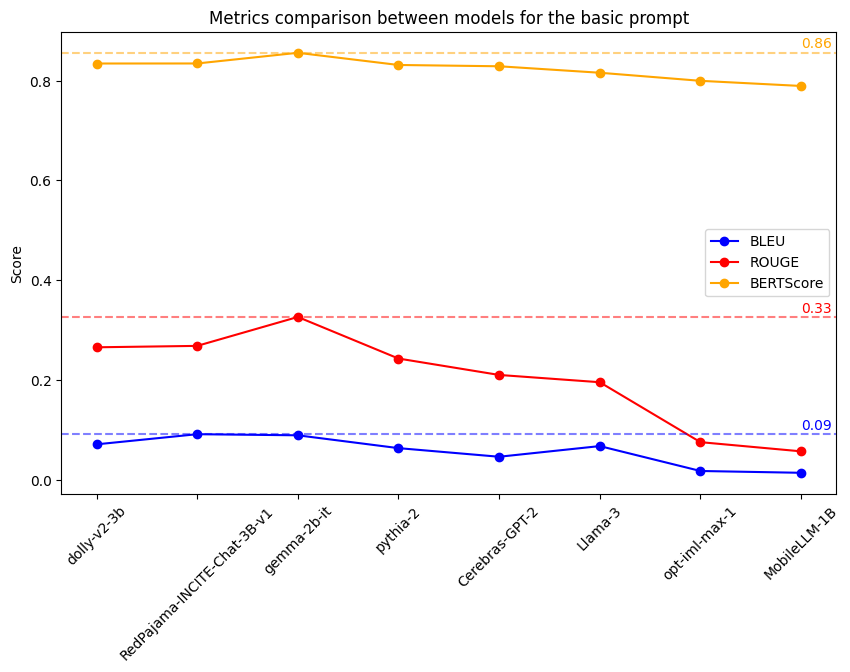

   TOP 3 MODELS

   BLEU                           ROUGE                          BERT                          
------------------------------------------------------------------------------------------
🥇 RedPajama-INCITE-Chat-3B-v1    gemma-2b-it                    gemma-2b-it                   
🥈 gemma-2b-it                    RedPajama-INCITE-Chat-3B-v1    RedPajama-INCITE-Chat-3B-v1   
🥉 dolly-v2-3b                    dolly-v2-3b                    dolly-v2-3b                   


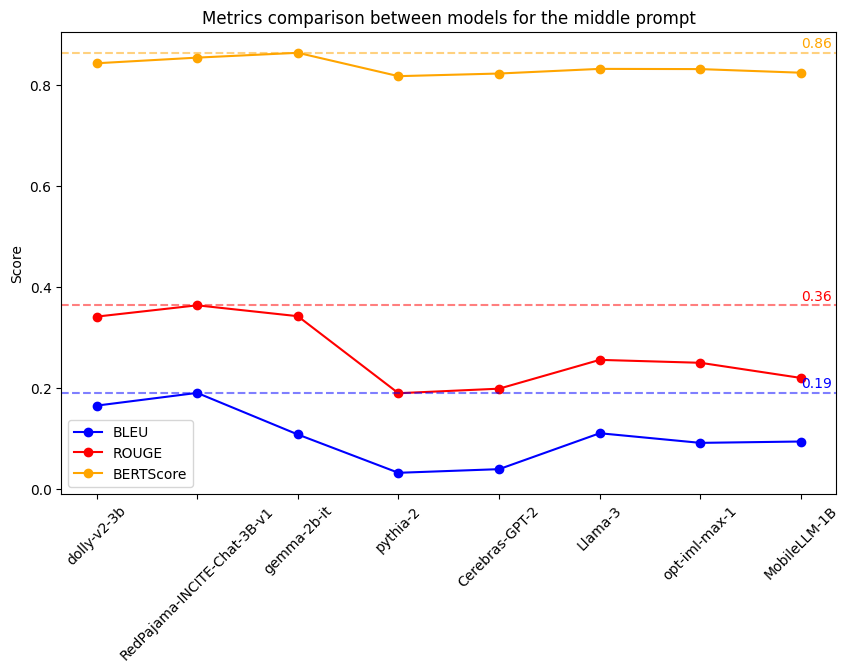

   TOP 3 MODELS

   BLEU                           ROUGE                          BERT                          
------------------------------------------------------------------------------------------
🥇 RedPajama-INCITE-Chat-3B-v1    RedPajama-INCITE-Chat-3B-v1    gemma-2b-it                   
🥈 dolly-v2-3b                    gemma-2b-it                    RedPajama-INCITE-Chat-3B-v1   
🥉 Llama-3                        dolly-v2-3b                    dolly-v2-3b                   


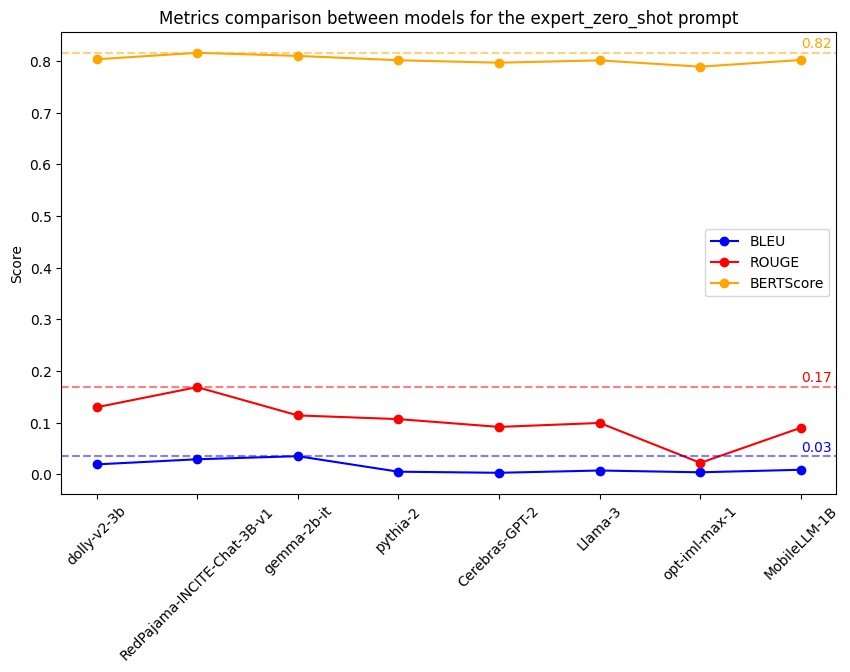

   TOP 3 MODELS

   BLEU                           ROUGE                          BERT                          
------------------------------------------------------------------------------------------
🥇 gemma-2b-it                    RedPajama-INCITE-Chat-3B-v1    RedPajama-INCITE-Chat-3B-v1   
🥈 RedPajama-INCITE-Chat-3B-v1    dolly-v2-3b                    gemma-2b-it                   
🥉 dolly-v2-3b                    gemma-2b-it                    dolly-v2-3b                   


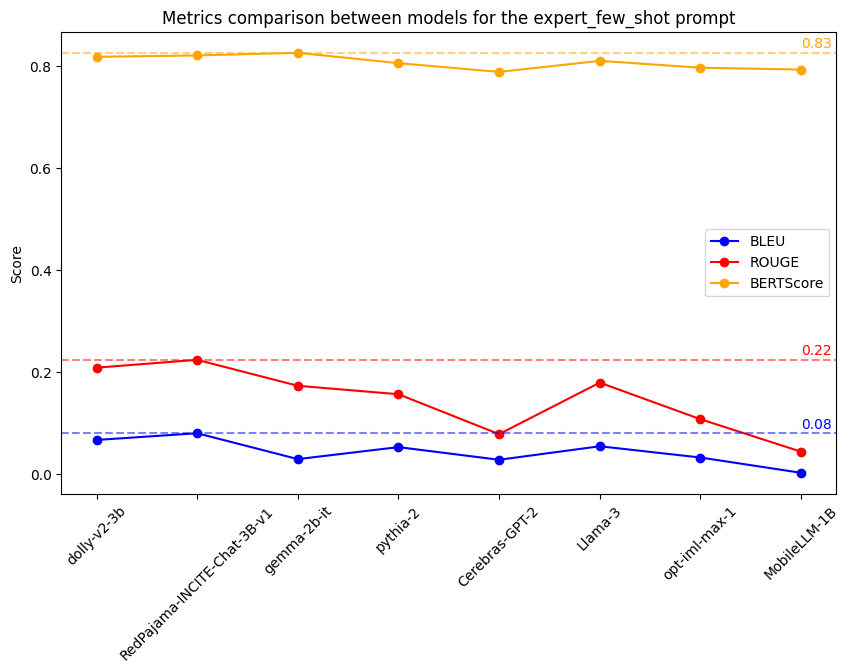

   TOP 3 MODELS

   BLEU                           ROUGE                          BERT                          
------------------------------------------------------------------------------------------
🥇 RedPajama-INCITE-Chat-3B-v1    RedPajama-INCITE-Chat-3B-v1    gemma-2b-it                   
🥈 dolly-v2-3b                    dolly-v2-3b                    RedPajama-INCITE-Chat-3B-v1   
🥉 Llama-3                        Llama-3                        dolly-v2-3b                   
{'bleu': (0.19028554851154506, 'RedPajama-INCITE-Chat-3B-v1', 'middle'), 'rouge': (0.3635229660538827, 'RedPajama-INCITE-Chat-3B-v1', 'middle'), 'bert': (0.8630706673860551, 'gemma-2b-it', 'middle')}


In [20]:
model_names = ["pegasus","bart"]
plot_results(dfs, models, model_names, 'basic', dic_max_scores)
plot_results(dfs, models, model_names, 'middle', dic_max_scores)
plot_results(dfs, models, model_names, 'expert_zero_shot', dic_max_scores)
plot_results(dfs, models, model_names, 'expert_few_shot', dic_max_scores)
print(dic_max_scores)

Comme on peut le remarquer, c'est souvent les mêmes modèles qui se trouvent dans le haut du classement. Si on recense le palamares olympique de ces champions de l'écriture, on obtient le tableau des médailles suivant:

| Modèle                       | Médailles                                                              |
|------------------------------|------------------------------------------------------------------------|
| RedPajama-INCITE-Chat-3B-v1  | 🥇🥇🥇🥇🥇🥇🥇🥈🥈🥈🥈🥈                                               |
| gemma-2b-it                  | 🥇🥇🥇🥇🥇🥈🥈🥈🥉                                                    |
| dolly-v2-3b                  | 🥈🥈🥈🥈🥉🥉🥉🥉🥉🥉🥉🥉                                              |
| Llama-3                      | 🥉🥉🥉                                                                   |


Le prix du meilleur score dans chaque metric revient à

| Metric                      | Modèle                       | Score    | Prompt    |
|-----------------------------|------------------------------|----------|-----------|
| BLEU                        | RedPajama-INCITE-Chat-3B-v1  | 0.190    | middle    |
| ROUGE                       | RedPajama-INCITE-Chat-3B-v1  | 0.364    | middle    |
| BERT                        | gemma-2b-it                  | 0.863    | middle    |

Le modèle RedPajama est donc le plus précis et a le meilleur rappel.

### Comparaison du temps d'inférence

GPU utilisé: 

![caractéristique du gpu](gpu.png)


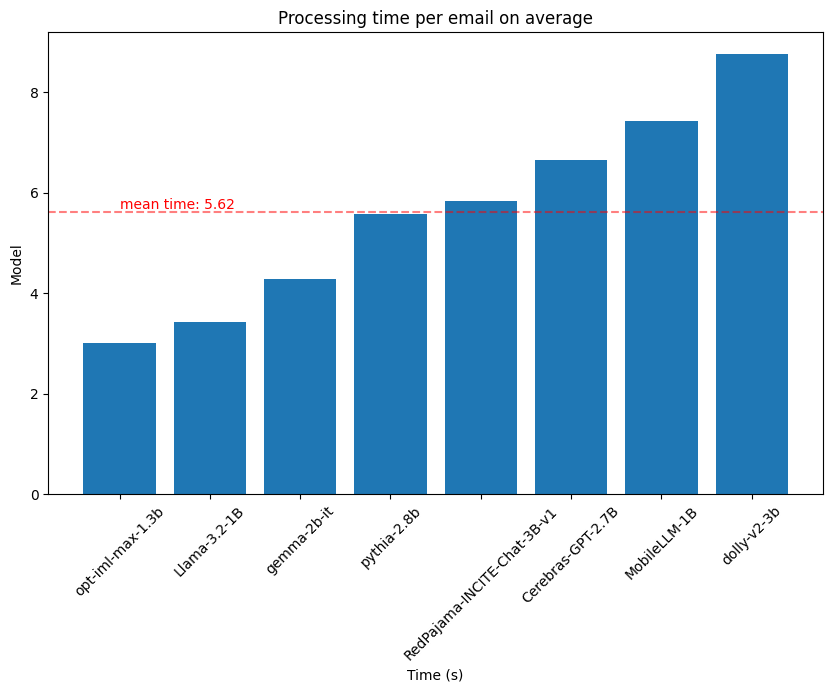

In [8]:
# plot time list

time_list_df = pd.read_csv("results/time_list.csv")
time_list = dict(zip(time_list_df["model"], time_list_df["time"]))

# compute mean time
mean_time = np.mean(list(time_list.values()))

# sort by time
time_list = {k: v for k, v in sorted(time_list.items(), key=lambda item: item[1])}

plt.figure(figsize=(10, 6))
plt.bar(list(time_list.keys()), list(time_list.values()))

# add a line at the mean time
plt.axhline(y=mean_time, color='red', linestyle='--', alpha=0.5)
plt.text(0, mean_time + 0.05, f'mean time: {mean_time:.2f}', color='red')

# put the label horizontaly
x = np.arange(len(time_list))
plt.xticks(x, list(time_list.keys()), rotation=45)
plt.xlabel("Time (s)")
plt.ylabel("Model")
plt.title("Processing time per email on average")
plt.show()

Comment on peut le voir sur le graphe, ce ne sont pas nécessairement les meilleures modèles qui prennent le plus de temps à l'inférence. En effet, Gemma et RedPajama ont un temps inférieur ou quasi égal à la moyenne.

### Comparaison des textes générés avec un exemple

In [35]:
print(small_df.iloc[2]['content'])

Jarrod:  Attached is the price correction language.  There is a 60 day true 
up with a 30 day notification period after the correction is announced.  Upon 
notification by a party, there is a 3 Business Day period for payment.  This 
language tracks the ISDA so that our approach in each instance will be 
identical.  We will need to add "Calculation Agent" to the confirmation.  
Please call if you have any questions.  Sara

P.S.  you should use a paralegal for Annex B purposes and if the omnibus is 
for a cross-border transaction


#### Reference: Pegasus

In [36]:
pegasus_ref = pd.read_csv('results_reference/pegasus_small.csv')
print(pegasus_ref.iloc[2]['pegasus'])

This language tracks the ISDA so that our approach in each instance will be identical .<n>You should use a paralegal for Annex B purposes and if the omnibus is for a cross-border


#### RedPajama

In [38]:
red_pajama = pd.read_csv('results/llm_6_RedPajama-INCITE-Chat-3B-v1_small.csv')
print(red_pajama.iloc[2]['middle'])


Jarrod, a large financial institution, is a party to a swap agreement with a counterparty, Sara. The agreement is a price-fixing agreement, and the parties have agreed to a 60-day true-up with a


#### Gemma

In [39]:
gemma = pd.read_csv('results/llm_1_gemma-2b-it_small.csv')
print(gemma.iloc[2]['middle'])


Jarrod has attached a price correction language document that outlines the following key points:

- There is a 60-day true up period followed by a 30-day notification period after the correction announcement.
- Upon notification,


#### Pythia

In [40]:
pythia = pd.read_csv('results/llm_5_pythia-2.8b_small.csv')
print(pythia.iloc[2]['middle'])


1.  The language tracks the ISDA.

2.  The language tracks the ISDA.

3.  The language tracks the ISDA.

4.  The language tracks the ISD


#### Opti-iml-max

In [42]:
opti = pd.read_csv('results/llm_7_opt-iml-max-1.3b_small.csv')
print(opti.iloc[2]['middle'])


Price Correction Language

Price Correction Language

Price Correction Language

Price Correction Language

Price Correction Language

Price Correction Language

Price Correction Language

Price Correction Language

Price Correction Language

Price Correction Language


### Interprétation

Ces observations nous montre de manière explicite que les textes générés par les modèles Gemma et RedPajama sont assez conformes à ce qu'on pourrait attendre d'un résumé, alors que des modèles moins performants Pythia et Opti-ml-max ont du mal à interpréter le prompt et génère quelque chose très peu qualitatif.

### Comparaison des prompts

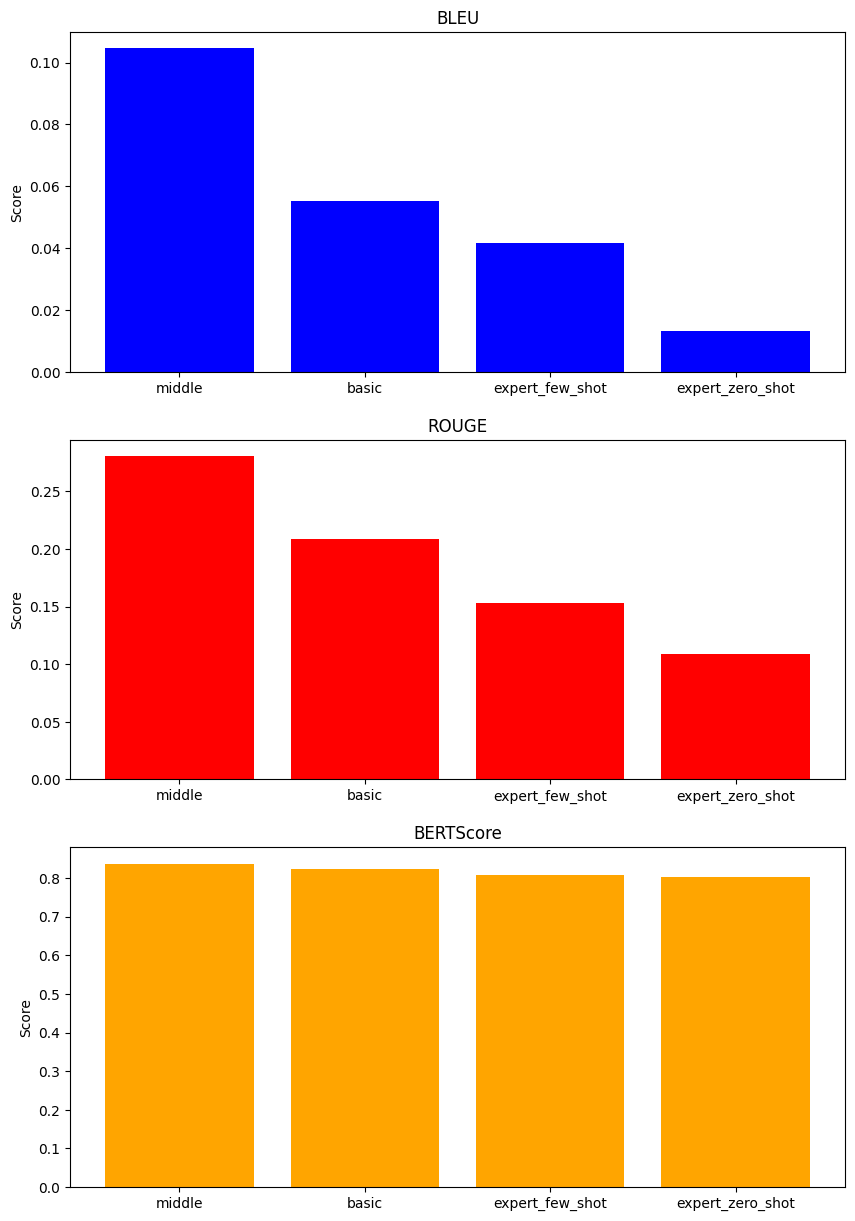

In [18]:
dic_max_scores = {"bleu":(0,"",""),"rouge":(0,"",""),"bert": (0,"","")}

def get_results(dfs, models, model_name, model_str):
    means_rouge = []
    means_bleu = []
    means_bert = []

    for column_name, _ in dfs.items():

        index_model = 0
        for model in models:
            if column_name in model:
                break
            index_model += 1

        df_eval = pd.read_csv(f"results_reference/llm_{index_model}_{column_name}_{model_name}.csv")
        
        columns = [col for col in df_eval.columns if model_str in col]

        means_bleu.append(df_eval[columns[0]].mean())
        means_rouge.append(df_eval[columns[1]].mean())
        means_bert.append(df_eval[columns[4]].mean())

    return np.mean(means_bleu), np.mean(means_rouge), np.mean(means_bert)

def plot_subplots_prompts(dfs, models, model_name, prompts):

    bert_dic = {}
    bleu_dic = {}
    rouge_dic = {}

    for prompt in prompts:
        bleu, rouge, bert = get_results(dfs, models, model_name, prompt)
        bert_dic[prompt] = bert
        bleu_dic[prompt] = bleu
        rouge_dic[prompt] = rouge

    _, axs = plt.subplots(3, 1, figsize=(10, 15))

    # sort the dictionaries
    bleu_dic = dict(sorted(bleu_dic.items(), key=lambda item: item[1], reverse=True))
    rouge_dic = dict(sorted(rouge_dic.items(), key=lambda item: item[1], reverse=True))
    bert_dic = dict(sorted(bert_dic.items(), key=lambda item: item[1], reverse=True))

    axs[0].bar(bleu_dic.keys(), bleu_dic.values(), color='blue')
    axs[0].set_title('BLEU')
    axs[0].set_ylabel('Score')

    axs[1].bar(rouge_dic.keys(), rouge_dic.values(), color='red')
    axs[1].set_title('ROUGE')
    axs[1].set_ylabel('Score')

    axs[2].bar(bert_dic.keys(), bert_dic.values(), color='orange')
    axs[2].set_title('BERTScore')
    axs[2].set_ylabel('Score')

    plt.show()


plot_subplots_prompts(dfs, models, model_name, ["basic","middle","expert_zero_shot","expert_few_shot"])

Comme le montre les différents graphiques, le middle prompt semble être le meilleur. On donnant des instructions claires et précises à notre LLM, on est capable d'améliorer (parfois x2) le score de notre modèle. Cependant, une chose d'assez consternante est les résultats du zero shot learning et du few-shot learning. En effet, on remarque que ceux-ci sont inférieur au score du prompt basic, à savoir fd;lr, ce qui est plutôt troublant dans le sens où c'est le prompt le plus simple qu'il existe pour demander un résumé à un générateur de texte. Selon nous, plusieurs raisons expliquent ce résultat consternant:

* Nos prompts expert sont mal écrit/adapté à la tâche ce qui déteriore la performance du LLM
* Le few-shot learning et le zero-shot ne sont pas adaptés à des tâches de summarization (du monde pour de "petits" LLMs). Il semble que les modèles ont du mal à capter le fait que les exemples qu'on leur donne sont des exemples de tâche à accomplir. Ces exemples prennent également une place assez conséquente dans le prompt étant donné que ce sont des emails de parfois plusieurs centaines de mots.

De plus, on remarque en analysant les résumés générés par les modèles que ceux-ci ont du mal à interpréter le fait que ce sont eux les "Agent". Pour illustrer nos propos, voici un exemple de résumé généré par le meilleur modèle RedPajama: 

| middle   |
|----------|

Approved for Janette Elbertson to go to Outlook 1082 on 3/29/01 from 1-2 p.m.

|### Key Points:

|1.  Janette Elbertson will attend","

| zero_shot |
|-----------|

[Your name]
[Your name]
[Your name]
[Your name]
[Your name]
[Your name]
[Your name]
[Your name]
[Your name]
[Your name"]

Néanmoins, on remarque le few_shot est meilleur que le zero_shot ce qui correspond bien aux résultats attendus dans la littérature.